In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *

import sys
sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

import backtest
import statsmodels.formula.api as smf
import statsmodels.api
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
import matplotlib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (15, 12)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SA', 'SM', "SF", 'nr', ]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'UR', 'lh', 'PK', 'CY'] # 'CY', 
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC', 'IM']
bond_fut_mkts = ['T', 'TF', 'TS']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [5]:
field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

factor_list = ['lrstd','upstd','lrskew','lrkurt','mincnt','volmf','oimf','trdstr','volmfratio']

shared_cols = ['date', 'split_idx']

rev_char = '!'
atr_win = 20
file_folder = "C:\\dev\\data\\data_cache\\"


start_date = datetime.date(2009,1,1)
end_date = datetime.date(2023,1,20)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 1
freq='d1'


data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        print("loading product = %s nb = %s" % (prodcode, nb))
        xdf = dataseries.nearby(prodcode,
                                  nb+1,
                                  start_date=start_date, 
                                  end_date=end_date, 
                                  shift_mode=shift_mode,
                                  freq=freq, 
                                  roll_name=roll_name, 
                                  config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)

xdata = df.loc[:,(df.columns.get_level_values(2) == 'close') 
               & (df.columns.get_level_values(1) == 'c1')].droplevel([1,2], axis=1)
logret = np.log(xdata).diff()
logret

print(df.tail(20), logret.tail(20))

loading product = rb nb = 0
loading product = hc nb = 0
loading product = i nb = 0
loading product = j nb = 0
loading product = jm nb = 0
loading product = ru nb = 0
loading product = FG nb = 0
loading product = SA nb = 0
loading product = SM nb = 0
loading product = SF nb = 0
loading product = nr nb = 0
loading product = cu nb = 0
loading product = al nb = 0
loading product = zn nb = 0
loading product = pb nb = 0
loading product = ni nb = 0
loading product = sn nb = 0
loading product = ss nb = 0
loading product = l nb = 0
loading product = pp nb = 0
loading product = v nb = 0
loading product = TA nb = 0
loading product = MA nb = 0
loading product = bu nb = 0
loading product = sc nb = 0
loading product = fu nb = 0
loading product = eg nb = 0
loading product = eb nb = 0
loading product = lu nb = 0
loading product = pg nb = 0
loading product = PF nb = 0
loading product = m nb = 0
loading product = RM nb = 0
loading product = y nb = 0
loading product = p nb = 0
loading product = OI nb = 0

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

col_list = ind_all_mkts
n_pca = 10

start_d = pd.to_datetime('2020-01-01')
end_d = pd.to_datetime('2023-01-20')

selected_logret = logret[(logret.index >= start_d) & (logret.index<=end_d)]
selected_logret = selected_logret[col_list].dropna()
print(selected_logret.head(10))
x_std = StandardScaler().fit_transform(selected_logret)

pca = PCA(n_components=n_pca)
pca.fit(x_std)
explained_ratio = pca.explained_variance_ratio_

product           rb        hc         i         j        jm        ru  \
date                                                                     
2020-10-14 -0.002760 -0.007161 -0.017996 -0.002381 -0.000370  0.011670   
2020-10-15 -0.001660 -0.008554 -0.013872 -0.005738 -0.005201 -0.002999   
2020-10-16  0.005522  0.004019 -0.002543  0.008118 -0.005602  0.037212   
2020-10-19 -0.005799  0.000000 -0.005745 -0.004768 -0.005634  0.017922   
2020-10-20  0.001384  0.001336  0.010191  0.007143  0.015325  0.042767   
2020-10-21  0.009359  0.011417  0.010088  0.013198  0.000742  0.004076   
2020-10-22 -0.002194  0.005791 -0.004401  0.000702  0.004438  0.007430   
2020-10-23 -0.007165 -0.006583 -0.028117 -0.008695 -0.006293 -0.001347   
2020-10-26 -0.000830  0.002639 -0.014361  0.011965 -0.002230  0.033789   
2020-10-27  0.000830  0.004470  0.009814  0.012515  0.003344  0.024136   

product           FG        SA        SM        SF        nr        cu  \
date                                 

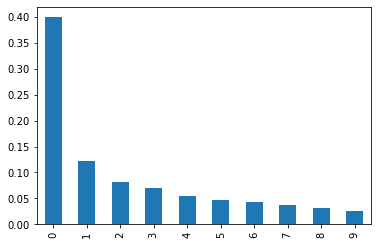

In [186]:
pd.Series(pca.explained_variance_ratio_).plot.bar()
plt.show()

In [110]:
x_std = StandardScaler().fit_transform(selected_logret)
pca = PCA(n_components=10)
pca.fit(x_std)
pca.components_[0]


array([0.15457232, 0.159226  , 0.15513082, 0.15440458, 0.1597704 ,
       0.11855288, 0.10448463, 0.13447895, 0.15244687, 0.11576408,
       0.17100342, 0.14492573, 0.13963738, 0.07276292, 0.12687098,
       0.13778106, 0.11456151, 0.18095494, 0.18552318, 0.1677566 ,
       0.18864283, 0.17281634, 0.1693982 , 0.16567012, 0.16935354,
       0.1663436 , 0.15900297, 0.1606398 , 0.14890278, 0.18981448,
       0.12142056, 0.13286863, 0.16800575, 0.16823587, 0.15566645,
       0.05790999, 0.10383579, 0.07943984, 0.15484965, 0.13061764,
       0.12843454, 0.04762991, 0.05052117, 0.12546158, 0.04968579,
       0.12089516, 0.11955264, 0.03454812, 0.08519852, 0.1254627 ,
       0.08971133, 0.12853896])

<AxesSubplot:>

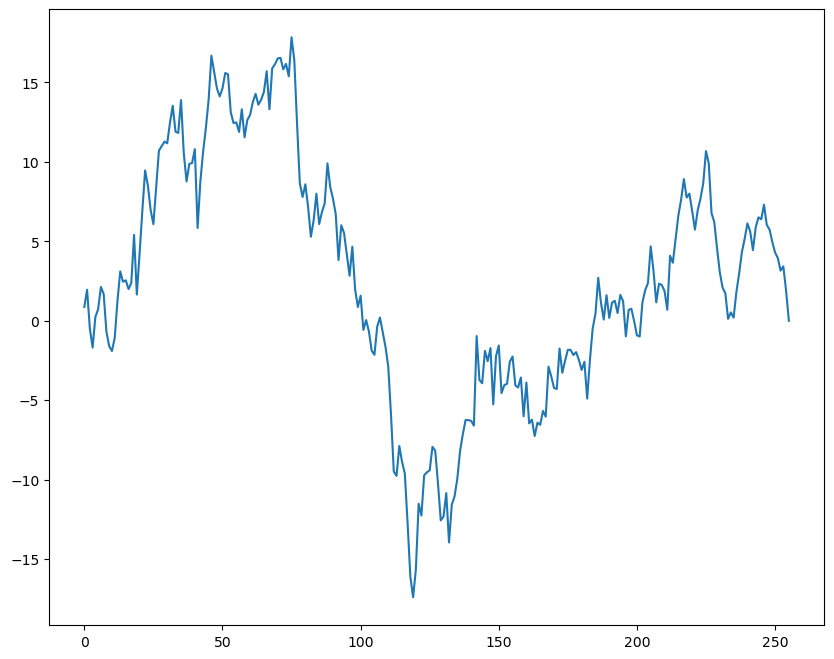

In [116]:
pd.Series(np.dot(x_std, pca.components_[2]).cumsum()).plot()

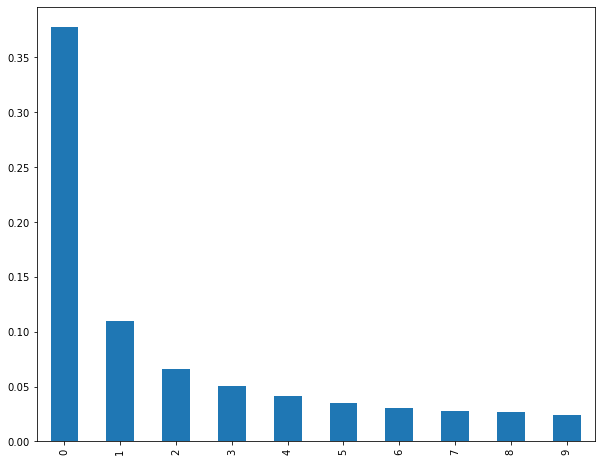

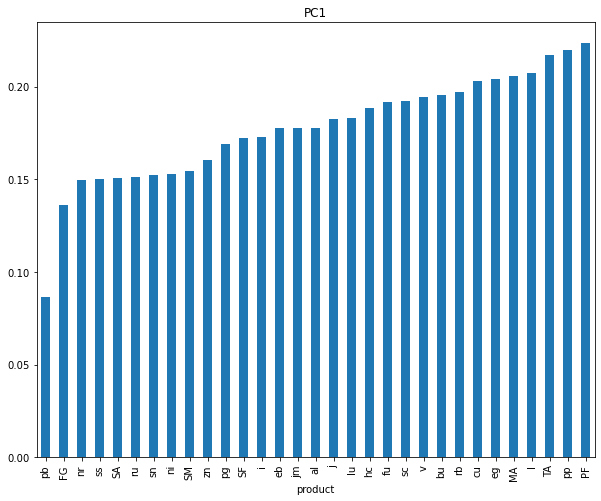

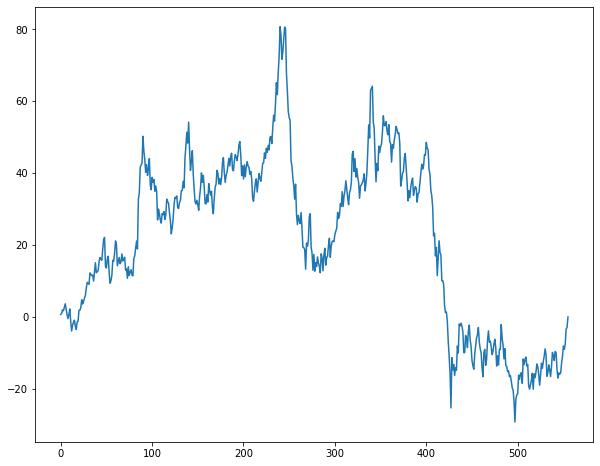

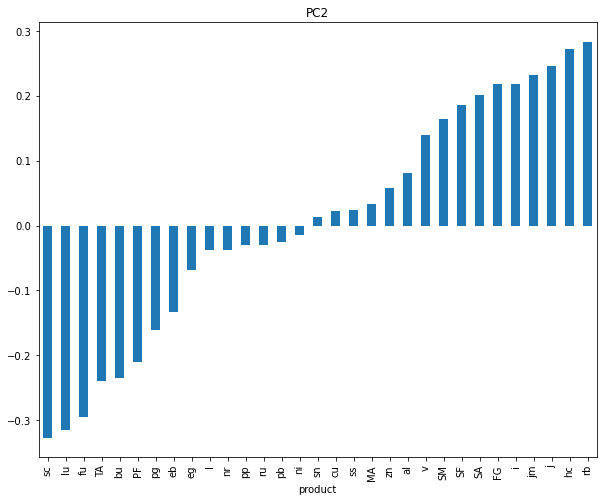

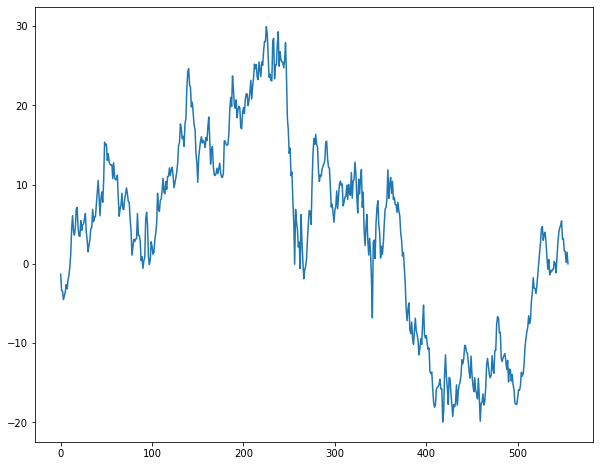

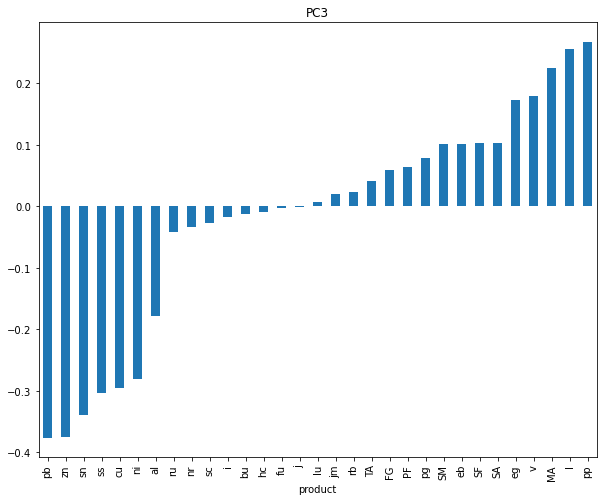

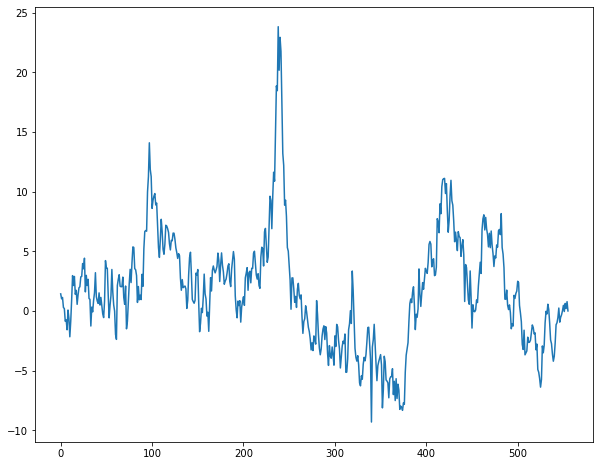

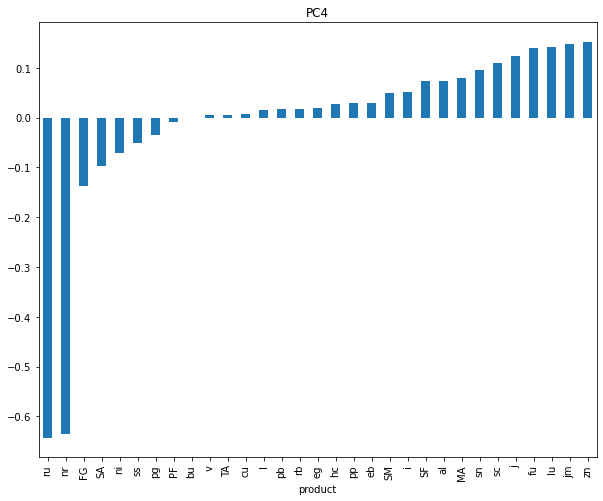

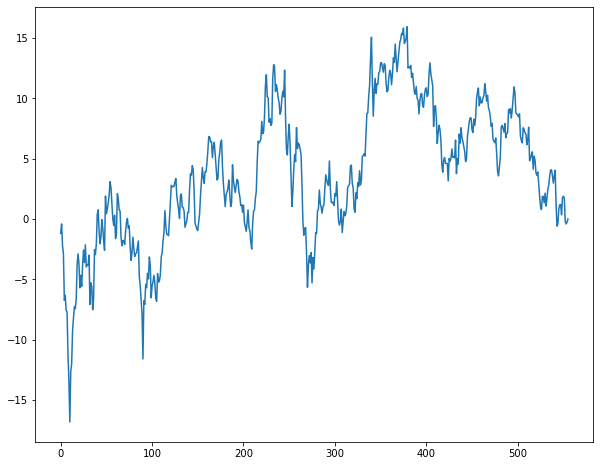

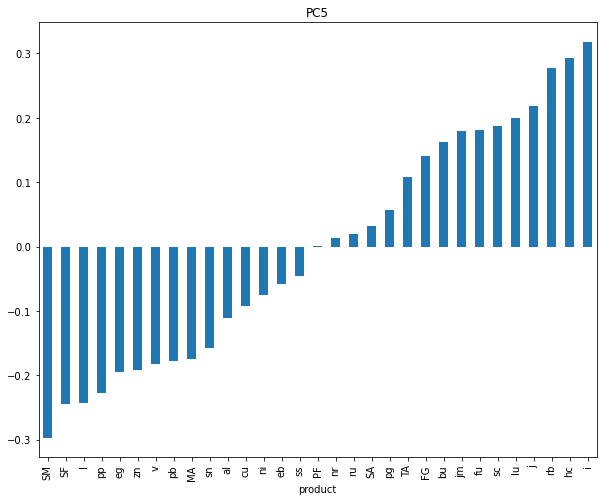

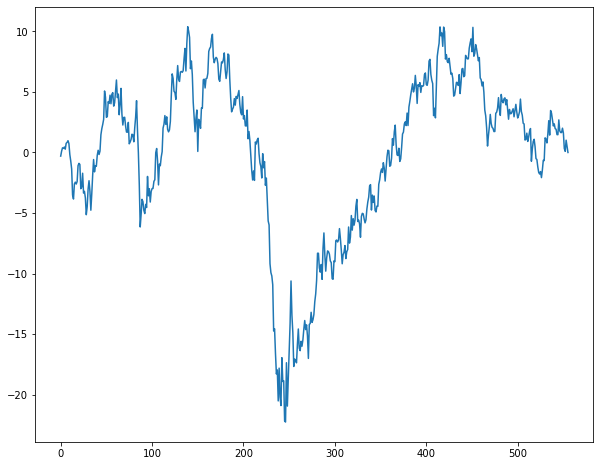

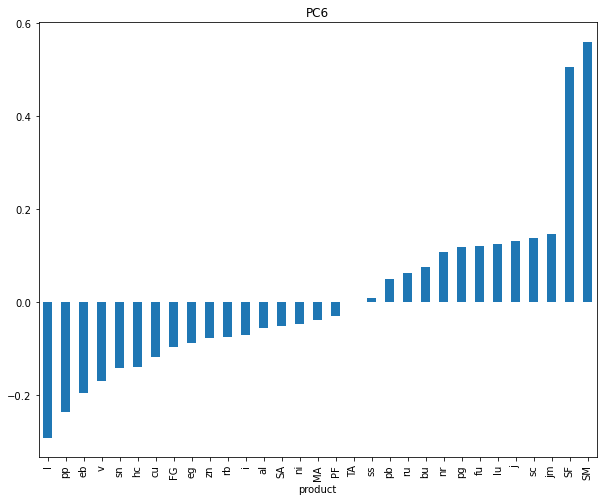

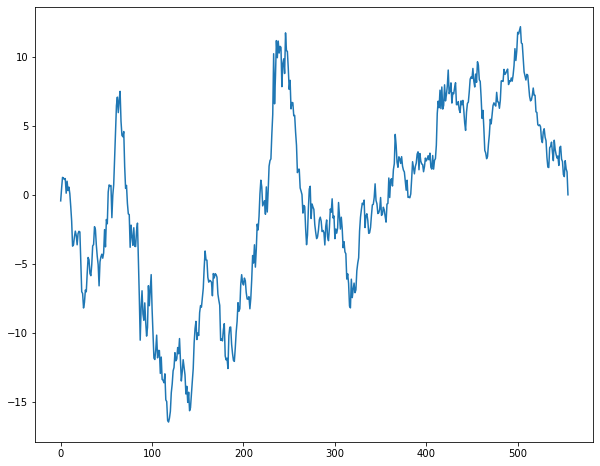

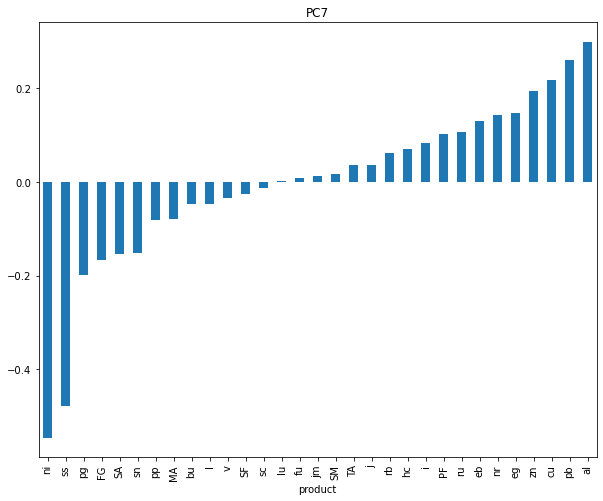

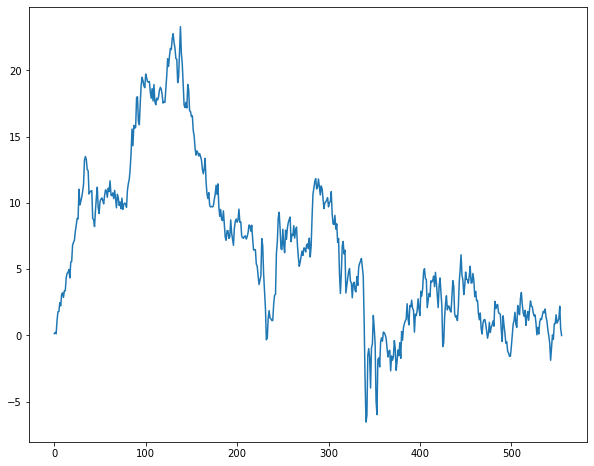

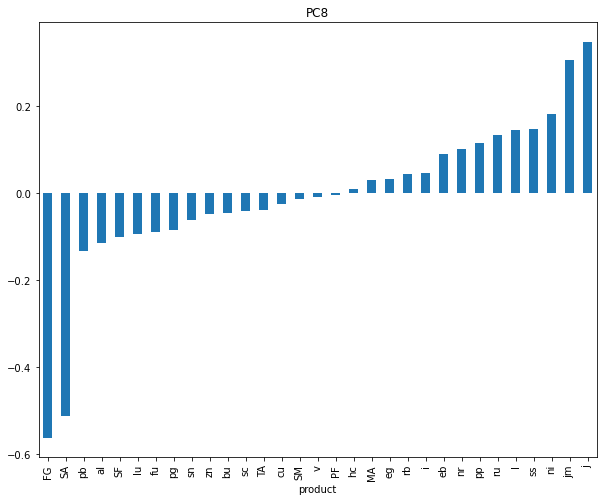

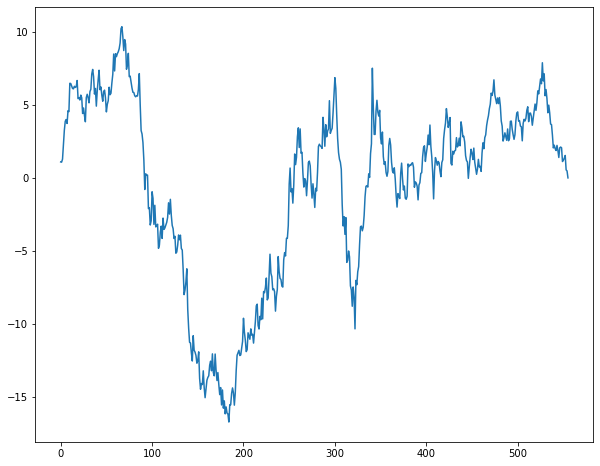

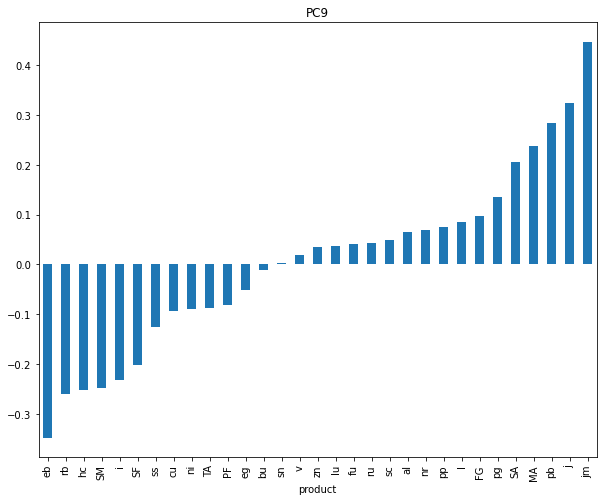

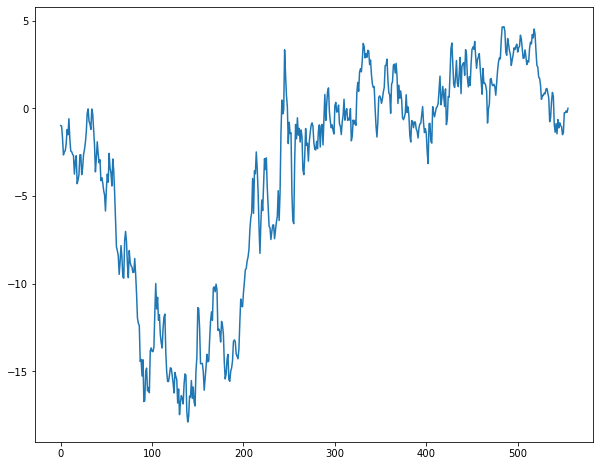

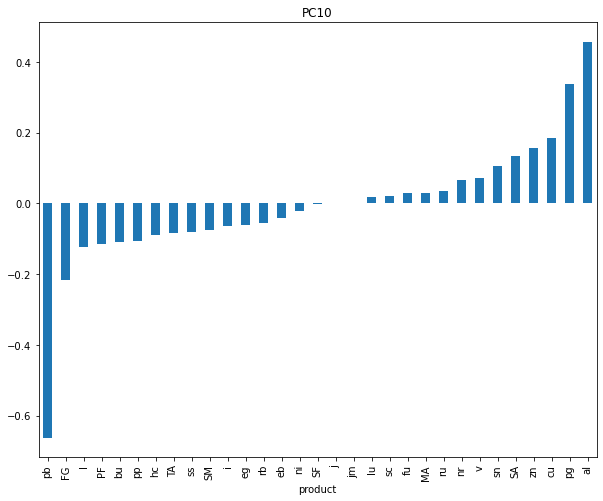

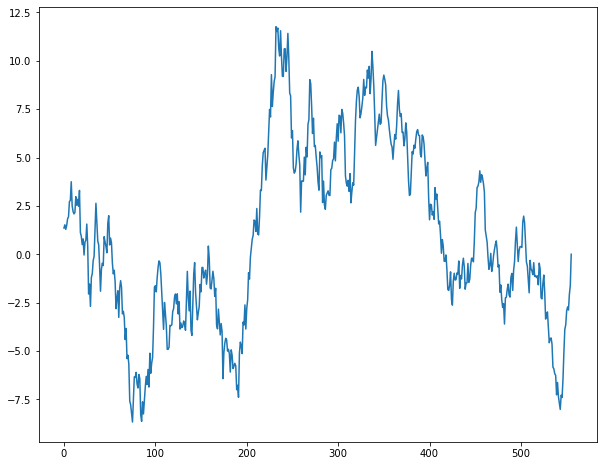

(PCA(n_components=10),
 {0: 0      0.701301
  1      0.282168
  2      1.004574
  3     -0.263380
  4      0.957370
           ...   
  551   -0.919709
  552    1.469625
  553    4.182229
  554    0.427764
  555    2.926318
  Length: 556, dtype: float64,
  1: 0     -1.295449
  1     -2.074077
  2     -0.062626
  3     -1.066175
  4      0.438170
           ...   
  551   -1.557221
  552   -0.056437
  553   -1.392122
  554    1.303628
  555   -1.482910
  Length: 556, dtype: float64,
  2: 0      1.431635
  1     -0.415677
  2      0.113584
  3     -0.839971
  4     -0.088568
           ...   
  551   -0.516032
  552    0.679414
  553   -0.429634
  554    0.578123
  555   -0.779155
  Length: 556, dtype: float64,
  3: 0     -1.188577
  1      0.785424
  2     -1.797989
  3     -0.678316
  4     -3.858891
           ...   
  551   -0.127387
  552   -1.955853
  553   -0.219354
  554    0.147408
  555    0.261526
  Length: 556, dtype: float64,
  4: 0     -0.300057
  1      0.408151
  2      0

In [8]:
matplotlib.rcParams['figure.figsize'] = (10, 8)

def plot_pca(data_df, n_pca = 10):
    x_std = StandardScaler().fit_transform(data_df)
    pca = PCA(n_components=n_pca)
    pca.fit(x_std)
    pd.Series(pca.explained_variance_ratio_).plot.bar()
    plt.show()
    product_list = data_df.columns
    eigen_port = {}
    for n in range(n_pca):
        ax = pd.Series(pca.components_[n], index=data_df.columns).sort_values().plot.bar()
        ax.set_title(f'PC{n+1}')
        plt.show()
        eigen_port[n] = pd.Series(np.dot(x_std, pca.components_[n]))
        eigen_port[n].cumsum().plot()
        plt.show()
    return pca, eigen_port

plot_pca(selected_logret)

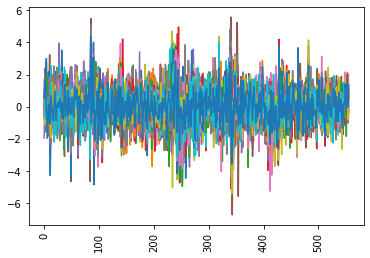

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

#A messy plot of all the processed adjusted closing prices
%matplotlib inline
plt.plot(x_std);
plt.xticks(rotation='vertical');

In [42]:
col_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', 'ni', \
               'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
               'AP', 'SM', 'SF', 'eb', 'eg', 'UR', 'CJ', 'ss', 'pg', 'lu', 'fu', 'SR', 'b', 'cs']

n_pca = 10

start_d = pd.to_datetime('2019-01-01')
end_d = pd.to_datetime('2023-01-20')

selected_lr = logret[(logret.index >= start_d) & (logret.index<=end_d)]
selected_lr = selected_lr[col_list].dropna()
print(selected_lr.head(10))


product           rb        hc         i         j        jm        ru  \
date                                                                     
2020-06-24  0.002766  0.000278  0.018325  0.003586  0.000000 -0.007238   
2020-06-29 -0.018963 -0.012284 -0.046458 -0.034334 -0.014815 -0.026001   
2020-06-30  0.003653  0.005043  0.011483 -0.002384  0.006800  0.011858   
2020-07-01  0.000280 -0.003079 -0.003364 -0.007722 -0.006374  0.004411   
2020-07-02  0.001961 -0.001122 -0.004728  0.001069  0.016907  0.014563   
2020-07-03  0.012792  0.011996  0.010775 -0.000534 -0.000839  0.010547   
2020-07-06 -0.000276 -0.000277  0.005344 -0.001069 -0.001259  0.011851   
2020-07-07  0.004413  0.006635  0.021747  0.004270 -0.003366 -0.006619   
2020-07-08  0.018539  0.018294  0.027011  0.016900  0.008393  0.010382   
2020-07-09  0.006462  0.005935  0.001268 -0.001310  0.017810  0.003749   

product           FG        cu        al        zn        pb        sn  \
date                                 

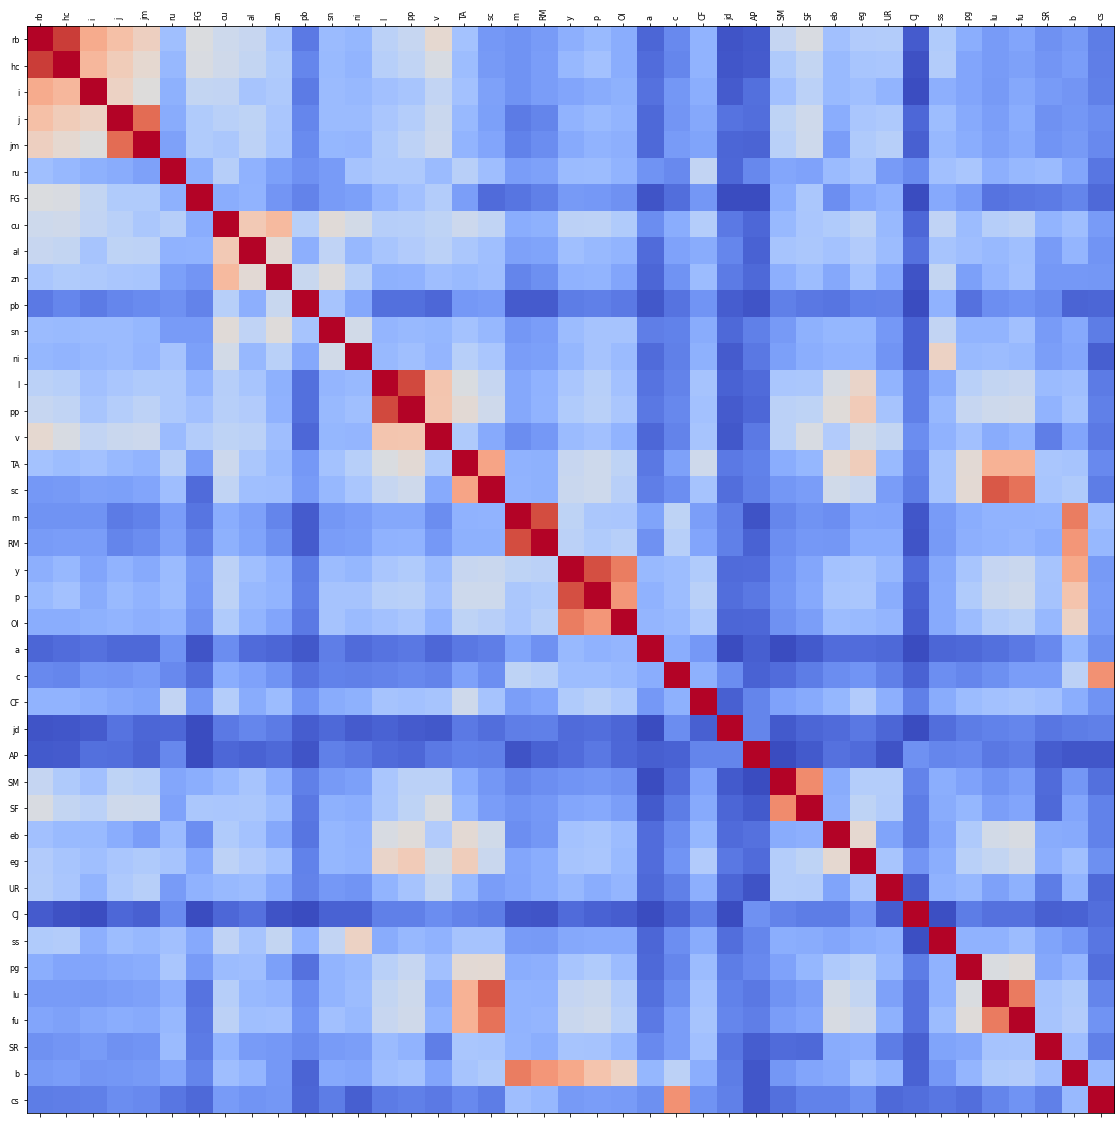

In [43]:
corr = selected_lr.corr()
size = 20
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);

In [54]:
import scipy.cluster.hierarchy as sch 
from scipy.spatial.distance import pdist
import pylab

Z = sch.linkage(corr, 'average')
print(Z[0])

c, coph_dists = sch.cophenet(Z, pdist(corr))
print(c)

[0.         1.         0.18232813 2.        ]
0.8459494254043232


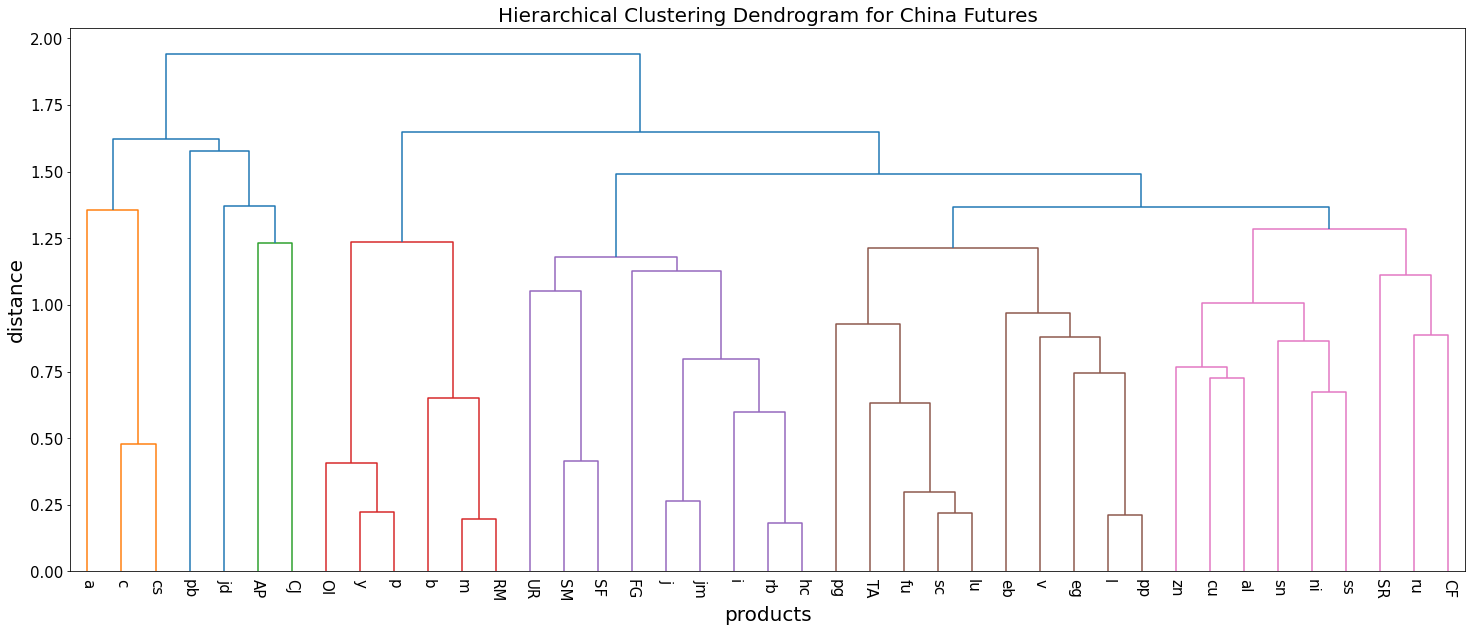

In [55]:
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for China Futures', fontsize=labelsize)
plt.xlabel('products', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
sch.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.savefig('dendogram_'+'china_fut'+'.png')
plt.show()

In [56]:
from scipy.cluster import hierarchy as sch
d = sch.distance.pdist(corr)
L = sch.linkage(d, method="average")
cutoff = 1.4
ind = sch.fcluster(L, cutoff, "distance")
pd.Series(ind, index=selected_lr.columns)


product
rb    5
hc    5
i     5
j     5
jm    5
ru    6
FG    5
cu    6
al    6
zn    6
pb    3
sn    6
ni    6
l     6
pp    6
v     6
TA    6
sc    6
m     4
RM    4
y     4
p     4
OI    4
a     1
c     1
CF    6
jd    2
AP    2
SM    5
SF    5
eb    6
eg    6
UR    5
CJ    2
ss    6
pg    6
lu    6
fu    6
SR    6
b     4
cs    1
dtype: int32

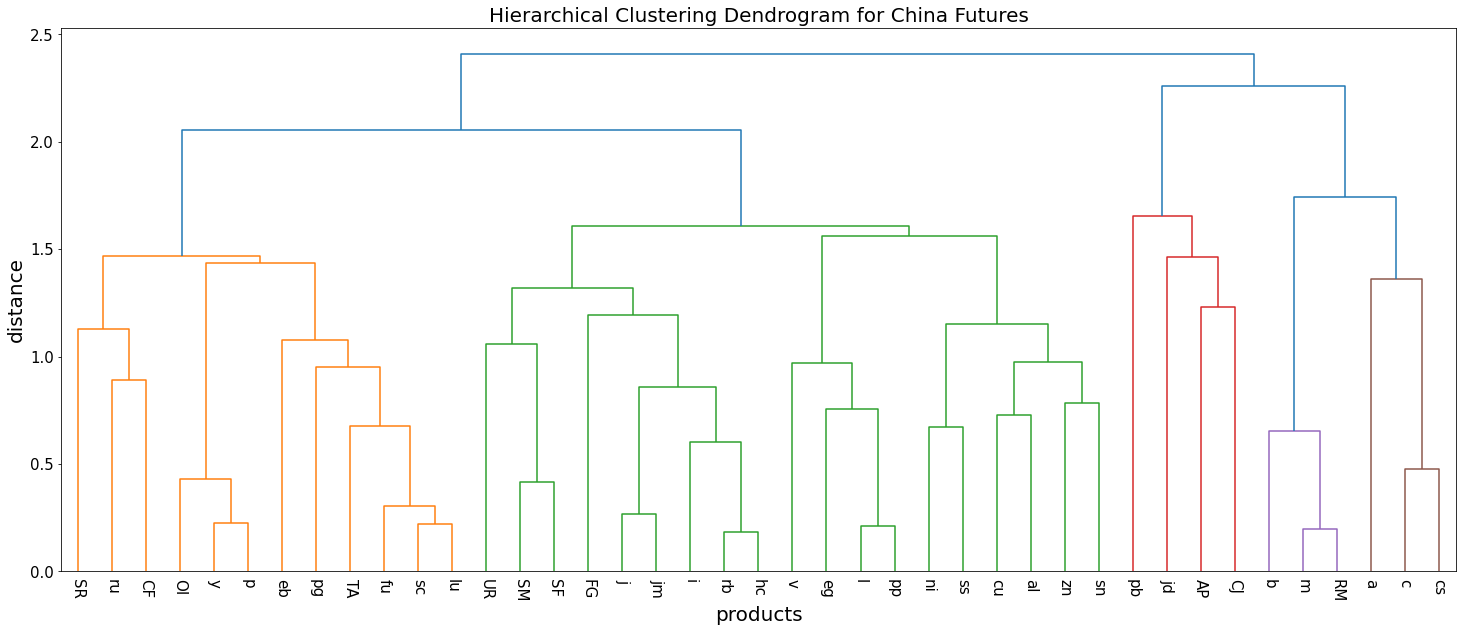

product
rb    2
hc    2
i     2
j     2
jm    2
ru    1
FG    2
cu    4
al    4
zn    4
pb    6
sn    4
ni    4
l     3
pp    3
v     3
TA    1
sc    1
m     7
RM    7
y     1
p     1
OI    1
a     8
c     8
CF    1
jd    5
AP    5
SM    2
SF    2
eb    1
eg    3
UR    2
CJ    5
ss    4
pg    1
lu    1
fu    1
SR    1
b     7
cs    8
dtype: int32

In [62]:
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for China Futures', fontsize=labelsize)
plt.xlabel('products', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)



distance_matrix = sch.linkage(sch.distance.pdist(corr), method='complete')
dn = sch.dendrogram(distance_matrix,
                    leaf_rotation=90.,  # rotates the x axis labels
                    leaf_font_size=8.,  # font size for the x axis labels
                    labels=corr.columns)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)

plt.show()

threshold = 1.5
labels = sch.fcluster(distance_matrix, threshold, criterion='distance')
pd.Series(labels, index=selected_lr.columns)